In [1]:
from wv_utils import reduce_dimensions, create_angle_matrix
from note_reader import get_notes_as_pitch_classes
from gensim.models import Word2Vec, FastText
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob

In [2]:
plt.rcParams["font.family"] = ["Times"]
UNK_TAG = "<UNK>"

In [3]:
file_list = glob.glob("data/txt/*.txt")

In [4]:
docs, counts = get_notes_as_pitch_classes(file_list)

In [5]:
pitches_sorted = counts.most_common()
pitches, pitch_counts = zip(*pitches_sorted)

In [6]:
THRESHOLD = 20

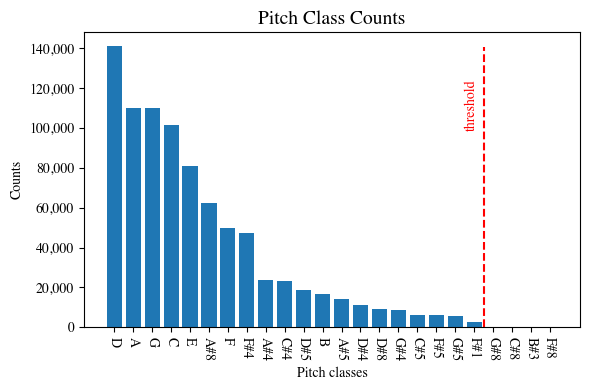

In [7]:
fig = plt.figure(figsize=(6, 4))
plt.title("Pitch Class Counts", fontdict={"fontsize": 14})
plt.xlabel("Pitch classes")
plt.xticks(rotation=-90)
plt.ylabel("Counts")
plt.gca().yaxis.set_major_formatter(
    plt.matplotlib.ticker.StrMethodFormatter("{x:,.0f}"))
plt.bar(pitches, pitch_counts)
plt.tight_layout()
plt.axvline(x=THRESHOLD-0.5, ymax=0.95, color="r", linestyle="--")
plt.text(THRESHOLD-1.5, 100000, "threshold", rotation=90, color="r")
plt.show()

In [8]:
common_pitches = [x[0] for x in counts.most_common(THRESHOLD)]
common_docs = []
for doc in docs:
    common_doc = [x if x in common_pitches else UNK_TAG for x in doc]
    common_docs.append(common_doc)

# Word2Vec model


In [9]:
w2v_model = Word2Vec(sentences=common_docs,
                     vector_size=10, epochs=100, window=7)
w2v_model.wv.most_similar(positive=["C", "A"], negative=["G"], topn=3)  # D

[('A#8', 0.5240300893783569),
 ('D', 0.44729316234588623),
 ('C#5', 0.4129626750946045)]

In [10]:
w2v_model.wv.most_similar("G")

[('F#4', 0.7139037847518921),
 ('D#5', 0.44270235300064087),
 ('D#8', 0.3197578489780426),
 ('G#5', 0.3093819320201874),
 ('A#4', 0.2057047337293625),
 ('D#4', 0.18923217058181763),
 ('A#5', 0.03497335687279701),
 ('C#4', 0.025171460583806038),
 ('A', -0.005995769985020161),
 ('<UNK>', -0.028060073032975197)]

In [11]:
w2v_model.wv.similarity("G", "A")

-0.0059957546

# FastText model


In [12]:
ft_model = FastText(sentences=common_docs, vector_size=10,
                    epochs=100, window=5, seed=42)
wv = ft_model.wv
wv.most_similar(positive=["C", "A"], negative=["G"])  # D

[('D', 0.586787223815918),
 ('A#8', 0.5630422830581665),
 ('C#5', 0.3581985831260681),
 ('B', 0.27972713112831116),
 ('E', 0.2749968469142914),
 ('F#1', 0.05926115810871124),
 ('C#4', -0.10165557265281677),
 ('A#4', -0.157062366604805),
 ('F#5', -0.19042308628559113),
 ('A#5', -0.23938091099262238)]

In [13]:
angles_dict = create_angle_matrix(wv)
df = pd.DataFrame.from_dict(angles_dict)
df.to_excel("results/angles.xlsx")

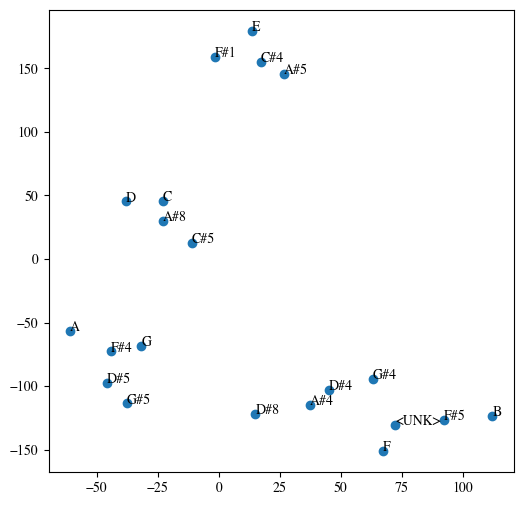

In [14]:
x_vals, y_vals, labels = reduce_dimensions(wv)
plt.figure(figsize=(6, 6))
plt.scatter(x_vals, y_vals)

for i in range(len(labels)):
    plt.annotate(labels[i], (x_vals[i], y_vals[i]))

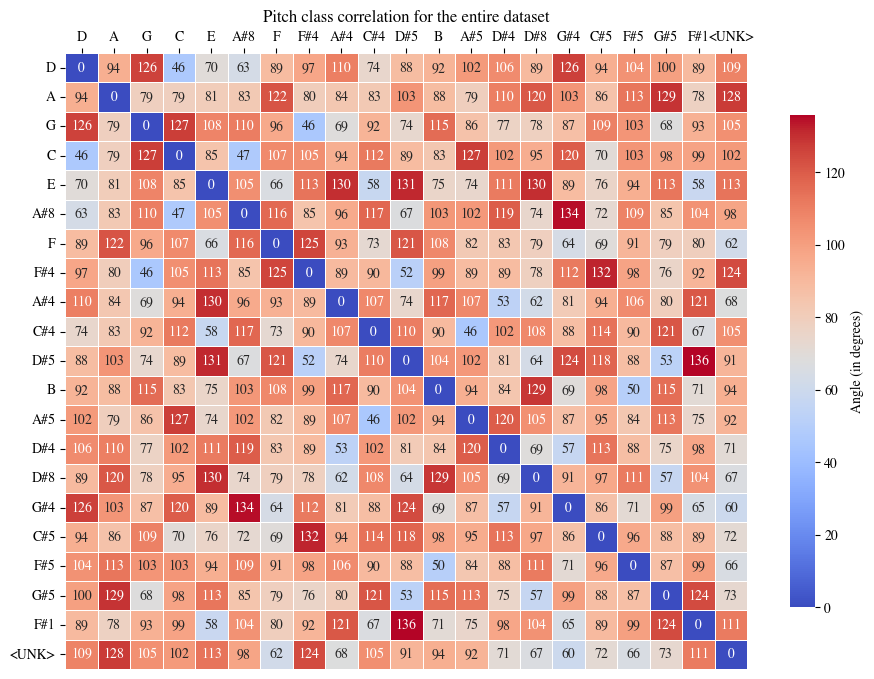

In [17]:
fig, ax = plt.subplots(figsize=(11, 8))
hm = sns.heatmap(df, cmap="coolwarm", annot=True, fmt=",.0f",
                 linewidths=0.5, cbar_kws={"shrink": 0.8})
hm.set(title="Pitch class correlation for the entire dataset")
ax.collections[0].colorbar.set_label("Angle (in degrees)")
ax.xaxis.tick_top()
plt.show()
fig.savefig("results/overall_corr.pdf")